# Overview

The classification task is to predict whether a suspect was arrested or not and to predict whether a suspect was frisked or not. To make predictions for each classification task, I build a logistic regression model, random forest model, and a KNN means model. 

Model comparison and evaluation is performed throughout.

# Data Preparation

## Define and prepare class variables

In [1]:
# Import Libaries
import warnings
warnings.filterwarnings("ignore")

In [5]:
## Reusing the data cleaning code from Mini Lab
import pandas as pd
import numpy as np
import urllib
import json
import geopandas as gpd
import math 
import category_encoders as ce

%matplotlib inline
from scipy import stats
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# use seaborn plotting defaults
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

### Import cleaned dataset to use:

In [15]:
# import data and isolate response variable
df = pd.read_csv('nypd_cleaned.csv', low_memory=False)

y = df['arstmade']

### Use proper variable representations:

In [16]:
#Let's explore the data types first, so we know what our predictor variables look like
df.dtypes

Unnamed: 0     int64
pct            int64
ser_num        int64
datestop       int64
timestop       int64
recstat       object
inout         object
trhsloc       object
crimsusp      object
typeofid      object
explnstp      object
othpers       object
arstmade      object
offunif       object
frisked       object
searched      object
ac_proxm      object
rf_attir      object
cs_cloth      object
ac_incid      object
repcmd        object
revcmd         int64
sex           object
race          object
age           object
ht_feet        int64
ht_inch        int64
height_in      int64
weight         int64
haircolr      object
eyecolor      object
build         object
city          object
addrpct        int64
dtype: object

In [17]:
# Convert precinct from continuous to OBJECT 
df['pct'] = df['pct'].astype('category')

# Convert Reporting Officer's Command (repcmd) and age OBJECT columns to NUMERIC, so they are not changed as part of the BinaryEncoders code

df['repcmd'] = df['repcmd'].astype('category')
df['repcmd'] = df['repcmd'].cat.codes

df['age'] = df['age'].astype('category')
df['age'] = df['age'].cat.codes

In [18]:
# Capturing the variables that are categorical
cat_list = ['pct','recstat','inout','trhsloc','crimsusp','typeofid','explnstp','othpers',
 'arstmade','offunif','frisked','searched','ac_proxm','rf_attir','cs_cloth',
'ac_incid','sex','race','hairclr','eyecolor','build','city']

In [19]:
# Start the encoding process for the logistic regression 
ce_bin = ce.BinaryEncoder()
df = ce_bin.fit_transform(df)

### Our predictor variables will be whether or not an arrest was ultimately made by the police upon search AND whether or not a frisking occurred

In [20]:
df = df.drop('arstmade_1',axis=1) # drop this column since task1 predictor variable will be arstmade_0
df = df.drop('frisked_1', axis=1)# drop this column since task2 predictor variable will be frisked_0

### Here we will utilize two dataframes because our two tasks will take on different forms of data manipulation. Further explanation in the 'Modeling and Evaluation' section. 
- Essentially our task 1 dependent variable (arstmade_0) is imbalanced, so we will utilize SMOTE
- Task 2 dependent variable (frisked_0) is far more balanced, so we will use the df as is.

In [21]:
task1_df = df
task2_df = df

### Utilizing Recursive Feature Elimination (RFE), we will only use the 10 variables that are useful for Task 1's analysis. We will remove the other variables that are not needed.

In [18]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

task1_df_rfe_vars = task1_df.columns.values.tolist()
t1_X = task1_df.loc[:, task1_df.columns != 'arstmade_0']
t1_y = task1_df.loc[:, task1_df.columns == 'arstmade_0']

X_train, X_test, y_train, y_test = train_test_split(t1_X, t1_y, test_size=0.2, random_state=0)
columns = X_train.columns

col_names = list(task1_df.columns.values)

logreg = LogisticRegression()

t1rfe = RFE(logreg, 10) # select 10 best columns to predict on
t1rfe = t1rfe.fit(X_train, y_train.values.ravel())

print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), t1rfe.ranking_), col_names)))

Features sorted by their rank:
[(1, 'crimsusp_1'), (1, 'explnstp_1'), (1, 'eyecolor_0'), (1, 'frisked_0'), (1, 'inout_1'), (1, 'searched_0'), (1, 'trhsloc_1'), (1, 'typeofid_0'), (1, 'typeofid_1'), (1, 'typeofid_2'), (2, 'haircolr_1'), (3, 'sex_1'), (4, 'offunif_1'), (5, 'rf_attir_1'), (6, 'pct_2'), (7, 'pct_1'), (8, 'arstmade_0'), (9, 'crimsusp_3'), (10, 'searched_1'), (11, 'inout_0'), (12, 'cs_cloth_1'), (13, 'crimsusp_5'), (14, 'eyecolor_2'), (15, 'trhsloc_2'), (16, 'city_2'), (17, 'eyecolor_3'), (18, 'eyecolor_1'), (19, 'ac_proxm_1'), (20, 'pct_6'), (21, 'crimsusp_2'), (22, 'offunif_0'), (23, 'city_1'), (24, 'haircolr_3'), (25, 'haircolr_2'), (26, 'sex_0'), (27, 'race_1'), (28, 'cs_cloth_0'), (29, 'pct_5'), (30, 'pct_7'), (31, 'race_0'), (32, 'build_2'), (33, 'build_1'), (34, 'rf_attir_0'), (35, 'othpers_0'), (36, 'city_0'), (37, 'pct_3'), (38, 'recstat_1'), (39, 'recstat_0'), (40, 'pct_4'), (41, 'othpers_1'), (42, 'city_3'), (43, 'race_2'), (44, 'ht_feet'), (45, 'ht_inch'), (46, '

### Based on the RFE algorithm, these are the important variables we should keep for our Task 1 models. For binary variables, we will utilize the _0 suffix for easier interpretation.
- city_1
- crimsusp_5
- explnstp_0
- frisked_0
- inout_0
- offunif_0
- rf_attir_0
- searched_0
- sex_1
- trhsloc_0

In [19]:
## Given that our frisked, offunif, othpers, recstate features are binary, we're going to only need one instance of this variable.

## According to recursive feature elimination, these are the 10 best predictor variables, so let's put assign them
## to rfe_cols as our final variables.

t1_rfe_cols = ['city_1', 'crimsusp_5', 'explnstp_0', 'frisked_0', 'inout_0',
              'offunif_0', 'rf_attir_0', 'searched_0', 'sex_1', 'trhsloc_0'
             ]


### We will use RFE for Task 2's analysis also. We will remove variables that are not needed.

In [97]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

task2_df_rfe_vars = task2_df.columns.values.tolist()
t2_X = task2_df.loc[:, task2_df.columns != 'frisked_0']
t2_y = task2_df.loc[:, task2_df.columns == 'frisked_0']

t2_col_names = list(task2_df.columns.values)

logreg = LogisticRegression()

t2rfe = RFE(logreg, 10) # select 10 best columns to predict on
t2rfe = t2rfe.fit(t2_X, t2_y.values.ravel())

print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), t2rfe.ranking_), t2_col_names)))

Features sorted by their rank:
[(1, 'ac_proxm_1'), (1, 'arstmade_0'), (1, 'crimsusp_5'), (1, 'frisked_0'), (1, 'inout_0'), (1, 'offunif_1'), (1, 'race_2'), (1, 'rf_attir_0'), (1, 'searched_0'), (1, 'sex_1'), (2, 'city_1'), (3, 'pct_1'), (4, 'pct_3'), (5, 'haircolr_1'), (6, 'explnstp_1'), (7, 'crimsusp_3'), (8, 'crimsusp_2'), (9, 'crimsusp_4'), (10, 'city_0'), (11, 'searched_1'), (12, 'rf_attir_1'), (13, 'cs_cloth_0'), (14, 'pct_6'), (15, 'city_2'), (16, 'trhsloc_2'), (17, 'recstat_1'), (18, 'recstat_0'), (19, 'typeofid_2'), (20, 'sex_0'), (21, 'othpers_0'), (22, 'race_0'), (23, 'offunif_0'), (24, 'pct_7'), (25, 'crimsusp_1'), (26, 'build_1'), (27, 'race_1'), (28, 'trhsloc_1'), (29, 'haircolr_3'), (30, 'eyecolor_2'), (31, 'haircolr_2'), (32, 'inout_1'), (33, 'eyecolor_3'), (34, 'ht_inch'), (35, 'othpers_1'), (36, 'typeofid_1'), (37, 'city_3'), (38, 'ac_proxm_0'), (39, 'race_3'), (40, 'ht_feet'), (41, 'ac_incid_1'), (42, 'age'), (43, 'height_in'), (44, 'repcmd'), (45, 'ser_num'), (46, 't

### Based on the RFE algorithm, these are the important variables we should keep for our Task 2 models. For binary variables, we will utilize the _0 suffix for easier interpretation.
- ac_proxm_0
- arstmade_0
- crimsusp_2
- crimsusp_5
- inout_0
- recstat_0
- rf_attir_0
- sex_1
- city_1
- pct_1

In [20]:
## According to recursive feature elimination, these are the 10 best predictor variables, so let's put assign them
## to rfe_cols as our final variables.

t2_rfe_cols = ['ac_proxm_0', 'arstmade_0', 'crimsusp_2', 'crimsusp_5','inout_0', 'recstat_0', 'rf_attir_0', 'sex_1', 'city_1','pct_1'
           ]

# Modeling and Evaluation

We have selected F-measure to evaluate our different models. We are predicting whether or not a person will be frisked and also arrested in New York City in 2013. There did not seem to be a significant difference to preventing false positives (precision) or preventing false negatives (recall) and so we decided to use F-measure. F-measure combines both precision and recall and we believe that this holistic approach will better evaluate our different models.

## Task 1: Predicting whether an arrest was made for a search incident

In [20]:
## Assign new X and y values
task1_X = os_data_X[t1_rfe_cols]
task1_y = os_data_y['arstmade_0']

### Task 1, Model 1 (Logistic Regression):

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Per the Rubric instructions, we will utilize a 80/20 split for our training/test data
t1m1_X_train, t1m1_X_test, t1m1_y_train, t1m1_y_test = train_test_split(task1_X, task1_y, test_size=0.2, random_state=0) 

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(t1m1_X_train, t1m1_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### Predict + Accuracy Score

In [22]:
t1m1_y_pred = logreg.predict(t1m1_X_test)
print('Accuracy of logistic regression classifier on test set:', logreg.score(t1m1_X_test, t1m1_y_test))

Accuracy of logistic regression classifier on test set: 0.8294054582729888


##### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(t1m1_y_test, t1m1_y_pred)
print(confusion_matrix)

[[25096  1662]
 [ 7408 19001]]


##### Precision + Recall

In [24]:
from sklearn.metrics import classification_report
print(classification_report(t1m1_y_test, t1m1_y_pred))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85     26758
           1       0.92      0.72      0.81     26409

    accuracy                           0.83     53167
   macro avg       0.85      0.83      0.83     53167
weighted avg       0.85      0.83      0.83     53167



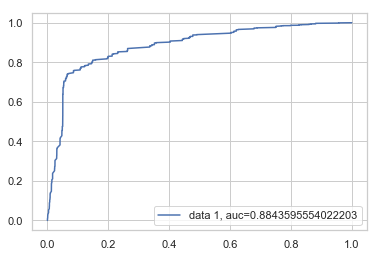

In [25]:
## ROC Curve + AUC Score (Task 1, Model 1)

t1m1_y_pred_proba = logreg.predict_proba(t1m1_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(t1m1_y_test,  t1m1_y_pred_proba)
auc = metrics.roc_auc_score(t1m1_y_test, t1m1_y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() ## https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

### AUC Explanation:
Measuring performance is an essential task when it comes to data mining, so let's try to better understand what an AUC score of 0.88 means! According to (https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5), an AUC score of 0 constitutes to a horrible model, a 0.5 score means our model does not do a good job of separating classes. The goal is to have our model produce an AUC score above 0.5 and 1, and that is exactly what we accomplish here. With an AUC score of 0.88, we produced a formidable Logistic Regression model. 

### Task 1, Model 2 (Random Forest)

In [26]:
from sklearn.tree import DecisionTreeClassifier
RSEED = 50

t1m2_X_train, t1m2_X_test, t1m2_y_train, t1m2_y_test = train_test_split(task1_X, task1_y, test_size=0.2, random_state=0) 

# Create the model with 100 trees
rf = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
rf.fit(t1m2_X_train, t1m2_y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

### Let's see how many nodes there are for each tree on average and the maximum depth of each tree. There were 100 trees in the forest.

In [27]:
n_nodes = []
max_depths = []

for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 395
Average maximum depth 9


We see that each decision tree in the forest has many nodes and isn't too deep. However, even though each individual decision tree may overfit to a particular subset of the training data, the idea is that the overall random forest should have a reduced variance.

#### Random Forest Results

In [28]:
train_rf_predictions = rf.predict(t1m2_X_train)
train_rf_probs = rf.predict_proba(t1m2_X_train)[:, 1]

rf_predictions = rf.predict(t1m2_X_test) # Actual class predictions
rf_probs = rf.predict_proba(t1m2_X_test)[:, 1] # Probabilities for each class

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [29]:
#Evaluate Random Forest Model Precision and Recall
from sklearn.metrics import classification_report

print('Accuracy of random forest classifier on test set:', rf.score(t1m2_X_test, t1m2_y_test))
print(classification_report(t1m2_y_test, rf_predictions))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Accuracy of random forest classifier on test set: 0.7758763351888069
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     26495
           1       0.75      0.83      0.79     26681

   micro avg       0.78      0.78      0.78     53176
   macro avg       0.78      0.78      0.78     53176
weighted avg       0.78      0.78      0.78     53176



[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [30]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
RF_cm = confusion_matrix(t1m2_y_test, rf_predictions)
print(RF_cm)

[[19128  7367]
 [ 4551 22130]]


In [31]:
from sklearn.metrics import roc_auc_score
# Calculate roc auc
roc_value = roc_auc_score(t1m2_y_test, rf_probs)
print('Receiver Operating Characteristic Area Under the Curve:', roc_value)

Receiver Operating Characteristic Area Under the Curve: 0.8582304844699475


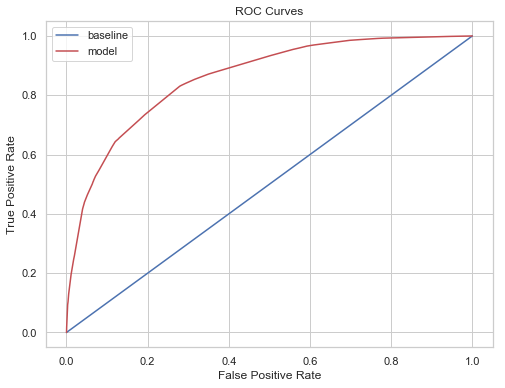

In [32]:
#Visualize ROC Curve for Task 1, Random Forest Model
# Calculate false positive rates and true positive rates
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
base_fpr, base_tpr, _ = roc_curve(t1m2_y_test, [1 for _ in range(len(t1m2_y_test))])
model_fpr, model_tpr, _ = roc_curve(t1m2_y_test, rf_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

### Feature Importance

The feature importances in a random forest indicate the sum of the reduction in Gini Impurity over all the nodes that are split on that feature. We can use these to try and figure out what predictor variables the random forest considers most important. The feature importances can be extracted from a trained random forest and put into a Pandas dataframe as follows:

In [33]:
#Feature importance on Task1 (arrest)
import pandas as pd

# Extract feature importances
fi = pd.DataFrame({'feature': list(t1m2_X_train.columns),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
3,frisked_0,0.358609
7,searched_0,0.317755
4,inout_0,0.158604
5,offunif_0,0.113469
1,crimsusp_5,0.021904


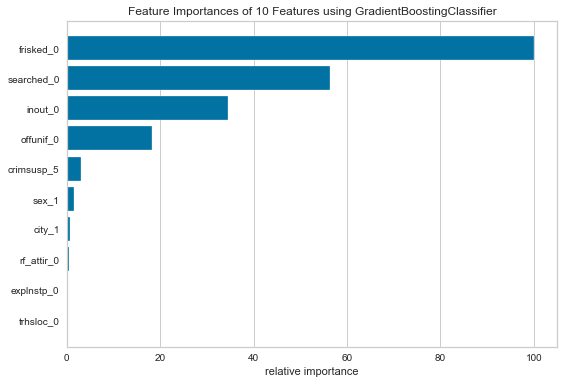

In [34]:
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(), ax=ax)
viz.fit(t1m2_X_train, t1m2_y_train)
viz.poof()

Feature importances can give us insight into a problem by telling us what variables are the most discerning between classes. For example, here frisked_0, indicating a frisked subject, is the most important feature which makes sense in the problem context.

### Random Forest Optimization through Random Search

In order to maximize the performance of the random forest, we can perform a random search for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values that perform the best.

In [35]:
from sklearn.model_selection import RandomizedSearchCV
RSEED = 50

rs_t1m2_X_train, rs_t1m2_X_test, rs_t1m2_y_train, rs_t1m2_y_test = train_test_split(task1_X, task1_y, test_size=0.2, random_state=0)

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'f1', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(rs_t1m2_X_train, rs_t1m2_y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, ...9, 49, 49, 49, 49, 49, 49, 49, 49, 50], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_job

In [36]:
rs.best_params_

{'n_estimators': 184,
 'min_samples_split': 2,
 'max_leaf_nodes': 40,
 'max_features': 0.7999999999999999,
 'max_depth': 14,
 'bootstrap': False}

We can see that the best hyperparameter values are not the defaults. This shows the importance of tuning a model for a specific dataset. Each dataset will have different characteristics, and the model that does best on one dataset will not necessarily do the best across all datasets.

### Task 1, Model 2 using optimized Random Forest parameters

In [37]:
best_model = rs.best_estimator_

In [38]:
train_rf_predictions_rs = best_model.predict(rs_t1m2_X_train)
train_rf_probs_rs = best_model.predict_proba(rs_t1m2_X_train)[:, 1]

rf_predictions_rs = best_model.predict(rs_t1m2_X_test)
rf_probs_rs = best_model.predict_proba(rs_t1m2_X_test)[:, 1]

In [39]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 79
Average maximum depth 8


In [40]:
#Evaluate Random Forest Model Precision and Recall using optimized RF settings
from sklearn.metrics import classification_report

print('Accuracy of random forest classifier on test set:', best_model.score(rs_t1m2_X_test, rs_t1m2_y_test))
print(classification_report(rs_t1m2_y_test, rf_predictions_rs))

Accuracy of random forest classifier on test set: 0.7759515570934256
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     26495
           1       0.75      0.83      0.79     26681

   micro avg       0.78      0.78      0.78     53176
   macro avg       0.78      0.78      0.78     53176
weighted avg       0.78      0.78      0.78     53176



In [41]:
#Confusion Matrix using optimized RF settings
from sklearn.metrics import confusion_matrix
RF_cm = confusion_matrix(rs_t1m2_y_test, rf_predictions_rs)
print(RF_cm)

[[19111  7384]
 [ 4530 22151]]


In [42]:
from sklearn.metrics import roc_auc_score
# Calculate roc auc using optimized RF settings
roc_value = roc_auc_score(rs_t1m2_y_test, rf_probs_rs)
print('Receiver Operating Characteristic Area Under the Curve:', roc_value)

Receiver Operating Characteristic Area Under the Curve: 0.8577849877006453


While our accuracy and ROC/AUC didn't show much improvement using optimized random forest parameters, we were still able to improve the cross validation of the model performance by determining the best RF settings, and improve overall accuracy by 1% over the logistic regression model. The max depth is lessened, and we decreased the number of nodes by 90%!

### Task 1, Model 3 (KNN)

In [44]:
#THIS CELL IS JUST SETTING SOME OF THE X/Y TRAIN/TEST SPLITS TO NEW DATA FRAMES
knn1_X_train = t1m1_X_train
knn1_y_train = t1m1_y_train
knn1_X_test = t1m1_X_test
knn1_y_test = t1m1_y_test

Here we begin running the first of two KNN models to predict the probability of arrest.
It is possible to use a grid search technique with the KNN model to define the distance metric, leaf size, weights, number of N, etc.. However for the sake of computing power and time, we will simply be modifying the number of neighbors used. Using the mean error for various K below we are able to see at which point the error decreases enough to be optimal without using too many neighbors.

We settled on 9 neighbors for this first model as it provided a balance between time to process and performance. The distance metric and others were left as is as it already took about 1.5 hours to determine the optimal amount of error.

#### The performance of this model was acceptable and in-line with previous models. A weighted average f1 score of .77 is comparable with .77 (Logreg), and .82 (RF).

#### The model performance on the test set was relatively similar to that on the train set showing that there is minimal overfitting. 

In [45]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=9)  
classifier.fit(knn1_X_train, knn1_y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [46]:
knn1_y_pred = classifier.predict(knn1_X_test)

In [47]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(knn1_y_test,knn1_y_pred))  
print(classification_report(knn1_y_test,knn1_y_pred))

[[21097  5398]
 [ 6905 19776]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.77     26495
           1       0.79      0.74      0.76     26681

   micro avg       0.77      0.77      0.77     53176
   macro avg       0.77      0.77      0.77     53176
weighted avg       0.77      0.77      0.77     53176



In [ ]:
#WARNING THIS WILL TAKE FOREVER TO RUN

error = []

for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(knn1_X_train, knn1_y_train)
    pred_i = knn.predict(knn1_X_test)
    error.append(np.mean(pred_i != knn1_y_test))

In [ ]:
#THIS PLOTS WHAT IS RUN IN THE CELL ABOVE. 

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

## Task 2: Predicting whether a search resulted in an officer frisking the suspect

### Task 2, Model 1 (Logistic Regression)

In [48]:
## we will not need to utilize the SMOTE technique for the 'frisked' since the classes are relatively balanced
task2_df['frisked_0'].value_counts(normalize=True)

## Let's set our dependent variable for Task 2
task2_X = task2_df[t2_rfe_cols]
task2_y = task2_df['frisked_0']

In [49]:
# Utilizing a 80/20 split for our training/test data
t2m1_X_train, t2m1_X_test, t2m1_y_train, t2m1_y_test = train_test_split(task2_X, task2_y, test_size=0.2, random_state=0) 

logreg = LogisticRegression(solver='lbfgs')
logreg.fit(t2m1_X_train, t2m1_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

##### Predict + Accuracy Score

In [50]:
t2m1_y_pred = logreg.predict(t2m1_X_test)
print('Accuracy of logistic regression classifier on test set:', logreg.score(t2m1_X_test, t2m1_y_test))

Accuracy of logistic regression classifier on test set: 0.669646079111728


##### Confusion Matrix

In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(t2m1_y_test, t2m1_y_pred)
print(confusion_matrix)

[[16702  4338]
 [ 7563  7422]]


#### Precision and Recall

In [52]:
from sklearn.metrics import classification_report
print(classification_report(t2m1_y_test, t2m1_y_pred))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74     21040
           1       0.63      0.50      0.56     14985

   micro avg       0.67      0.67      0.67     36025
   macro avg       0.66      0.64      0.65     36025
weighted avg       0.66      0.67      0.66     36025



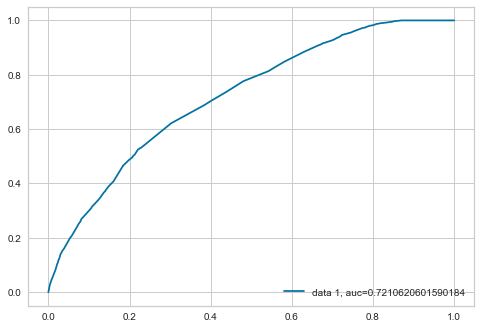

In [71]:
## ROC Curve + AUC Score (Task 2, Model 1)
t2m1_y_pred_proba = logreg.predict_proba(t2m1_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(t2m1_y_test,  t2m1_y_pred_proba)
auc = metrics.roc_auc_score(t2m1_y_test, t2m1_y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show() ## https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python

Measuring performance is an essential task when it comes to data mining, so let's try to better understand what an AUC score of 0.73 means! According to (https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5), an AUC score of 0 constitutes to a horrible model, a 0.5 score means our model does not do a good job of separating classes. The goal is to have our model produce an AUC score above 0.5 and 1, and that is exactly what we accomplish here. With an AUC score of 0.73, we produced a solid Logistic Regression model. 

### Task 2, Model 2 (Random Forest)

### For this RF model, we will use Random Search and build upon optimized parameters.

In [53]:
from sklearn.model_selection import RandomizedSearchCV
RSEED = 50

t2m2_X_train, t2m2_X_test, t2m2_y_train, t2m2_y_test = train_test_split(task2_X, task2_y, test_size=0.2, random_state=0) 

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'f1', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=RSEED)

# Fit
rs.fit(t2m2_X_train, t2m2_y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, ...9, 49, 49, 49, 49, 49, 49, 49, 49, 50], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_job

In [54]:
best_model = rs.best_estimator_

In [55]:
train_rf_predictions = best_model.predict(t2m2_X_train)
train_rf_probs = best_model.predict_proba(t2m2_X_train)[:, 1]

rf_predictions = best_model.predict(t2m2_X_test)
rf_probs = best_model.predict_proba(t2m2_X_test)[:, 1]

In [56]:
n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 79
Average maximum depth 9


In [57]:
#Evaluate Random Forest Model Precision and Recall using optimized RF settings
from sklearn.metrics import classification_report

print('Accuracy of random forest classifier on test set:', best_model.score(t2m2_X_test, t2m2_y_test))
print(classification_report(t2m2_y_test, rf_predictions))

Accuracy of random forest classifier on test set: 0.6738931297709924
              precision    recall  f1-score   support

           0       0.69      0.80      0.74     21040
           1       0.64      0.50      0.56     14985

   micro avg       0.67      0.67      0.67     36025
   macro avg       0.66      0.65      0.65     36025
weighted avg       0.67      0.67      0.67     36025



In [58]:
#Confusion Matrix using optimized RF settings
from sklearn.metrics import confusion_matrix
RF_cm = confusion_matrix(t2m2_y_test, rf_predictions)
print(RF_cm)

[[16820  4220]
 [ 7528  7457]]


In [59]:
from sklearn.metrics import roc_auc_score
# Calculate roc auc using optimized RF settings
roc_value = roc_auc_score(t2m1_y_test, rf_probs)
print('Receiver Operating Characteristic Area Under the Curve:', roc_value)

Receiver Operating Characteristic Area Under the Curve: 0.7283105253542517


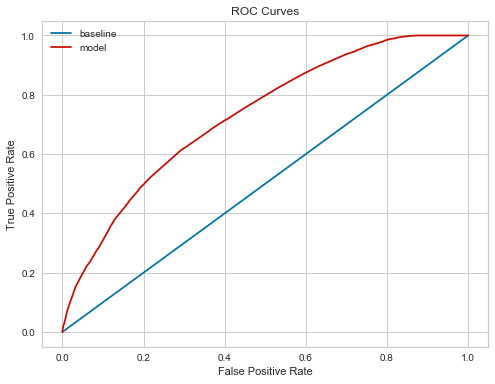

In [60]:
#Visualize ROC Curve for Task 2, Random Forest Model
# Calculate false positive rates and true positive rates
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
base_fpr, base_tpr, _ = roc_curve(t2m2_y_test, [1 for _ in range(len(t2m2_y_test))])
model_fpr, model_tpr, _ = roc_curve(t2m2_y_test, rf_probs)

plt.figure(figsize = (8, 6))
plt.rcParams['font.size'] = 16
    
# Plot both curves
plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
plt.plot(model_fpr, model_tpr, 'r', label = 'model')
plt.legend();
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

#### The F1-Score of the Random Forest (using random state) came in at .67, just slightly higher than the logistic regression model using random forest of 0.66.

#### Feature Importance

In [61]:
#Feature Importance on Task 2 (frisked)
import pandas as pd

# Extract feature importances
fi = pd.DataFrame({'feature': list(t2m2_X_train.columns),
                   'importance': best_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
6,rf_attir_0,0.367269
3,crimsusp_5,0.181253
1,arstmade_0,0.152607
4,inout_0,0.141266
7,sex_1,0.089416


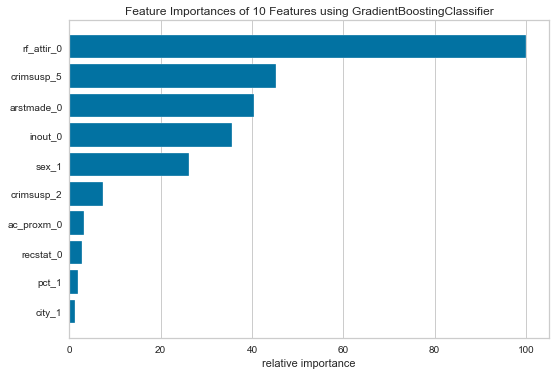

In [182]:
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(), ax=ax)
viz.fit(t2m2_X_train, t2m2_y_train)
viz.poof()

Feature importances for our second task, predicting a frisk, is above. Inapropriate attire for season (rf_attir_0) is the most important feature which makes sense in the problem context.

### Task 3, Model 3 (KNN)

In [62]:
#THIS CELL IS JUST SETTING SOME OF THE X/Y TRAIN/TEST SPLITS TO NEW DATA FRAMES

knn2_X_train = t2m1_X_train
knn2_y_train = t2m1_y_train
knn2_X_test = t2m1_X_test
knn2_y_test = t2m1_y_test

Much like the model above, we used similar settings, however the model, although providing acceptable perfomance falls somewhat behind the other models we tried. A weighted F1-score of 0.60 is slightly lower than both the Logreg (0.66) and Random Forest (0.67) models for task 2.

There is concern with the amount of overfitting and performance in the training model. Both the precision and recall of positive values (i.e. those who were frisked) is very low, indicating that there is a predisposition to classify it as a no frisk event. This is likely a result of the distribution in the original data. 

In [63]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(knn2_X_train, knn2_y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [64]:
knn2_y_pred = classifier.predict(knn2_X_test)  

In [65]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(knn2_y_test,knn2_y_pred))  
print(classification_report(knn2_y_test,knn2_y_pred)) 

[[17300  3740]
 [ 9688  5297]]
              precision    recall  f1-score   support

           0       0.64      0.82      0.72     21040
           1       0.59      0.35      0.44     14985

   micro avg       0.63      0.63      0.63     36025
   macro avg       0.61      0.59      0.58     36025
weighted avg       0.62      0.63      0.60     36025



In [ ]:
#WARNING THIS WILL TAKE FOREVER TO RUN

error = []

for i in range(1, 40):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(knn2_X_train, knn2_y_train)
    pred_i = knn.predict(knn2_X_test)
    error.append(np.mean(pred_i != knn2_y_test))

In [ ]:
#THIS PLOTS WHAT WE RAN ABOVE

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

For our first classification task, predicting whether or not a person was arrested, all of our models performed comparably with averaged F-meaure scores of .77, .78, and .77 respectively to logistic regression, random forest, and KNN. Even comparing the break down of Type I and Type II errors, they were all very similar. It doesn not seem like one model is advantageous over another and the data appears to lend itself to predicting whether or not a person was arrested.

Our second classification task of predicting whether or not a person would be frisked by a police officer was decidedly more difficult to model. Our logistic regression and random forest models performed comparably with weight average f-measures of .66 and .67 respectively. Though our KNN means model did not perform as well for this classification task with an average f-measure of .60. It is possible that the KNN means model did not peform as well because it struggles with high dimensional data such as our data set. For predicting whether or not a person was frisked we saw significant enough improvement with our logistic regression and random forest models, that we would probably use these in the future.

## Which attributes from your analysis are most important?

The most important factors in our model to determine whether or not a person was arrested were whether or not they were frisked or searched, whether they were inside or outside, and whether or not they were suspected of a particular crime. These seem logical in that the data we had went far enough to determine whether or not someone would likely be arrested.

The most important factors to whether or not a person was frisked were if they were suspected of a crime, gender (male), and if they were in a certain area - near crime, city, and precinct. All of these seem reasonable at face value that an area already experiencing high crime would probably have a higher police presence to begin with which would lead to more people being stopped and frisked. Interestingly the highest weighted variable for whether or not someone was stopped and frisked was their attire. This would definitely be interesting to look into more to check for bias within procedures. Perhaps it is affiliation with a certain group, such as a street gang, which makes someone more likely to be frisked. It is also possible that police officers are more likely to target a style of dress which is more popular with an age group or race. If this is the case, then it is likely that there is still illegal factors being used in whether or not someone is stopped and frisked because there is legal precedent with bars not being allowed to have discrimantory dress codes.



# Deployment

Our intention all along has been to build these models for the NYPD in order to better their decision-making practices in regard to who they arrest, and now also who they stop and frisk. This data set began being collected in the early 2000s due to the valid concern that there was significant bias demonstrated in the people NYPD was stopping and frisking and arresting. This discrimination violated federal laws.  Thus, it was decided that the data collection was essential to tracking the police department’s actions in order to bring their operating procedures within legal compliance.

To improve these practices, our models may not be especially helpful to the NYPD. It is not realistic that a police officer would enter all of these factors about a person into a model and let the model decide on whether or not the person should be frisked or arrested. We have seen similar models in place in judicial sentencings and know that they tend to propagate, and not curb, bias.

However, other parts of our analysis such as variable selection may be very helpful. If we are predicting who is actually arrested and we are working on the assumption that the arrests occurring are valid, then identifying variables which are weighted of very low or very high importance might be useful. 

One bright side of the variable selection in our model was that some of variables which were significantly low were physical attributes that may demonstrate prejudice such as weight, build, and eye and hair color. While we only looked at one year of data (2013), it is possible that these indicate improvement in police officers making more objective, and less biased, decisions. Adding additional years to our model would also bolster the meaningfulness of our results. We chose a year where the NYPD was under scrutiny, but before the court system, demanded changes. Adding prior and subsequent years would demonstrate trends and track progress significantly better than our models based around our current one year of data.

# Exceptional Work

## Grid Search for Logistic Regression

### Task 1 - Logistic Regression Grid Search

Let's try using Grid Search to maximize the F1-Score for our task 1 Logistic Regression model. The hyperparameters we tuned are:

Penalty: l1 or l2 which specifies the norm used in the penalization.

C: Inverse of regularization strength- smaller values of C specify stronger regularization.

From the confusion matrix below, we can see that by tuning using grid search, we are able to increase the F1 score by almost 2%. It is now the highest performing model (by F1-Score) at 0.79.

(source): https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e

In [66]:
#Grid Search for task one, model one (LogReg)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'f1')
grid_clf_acc.fit(t1m1_X_train, t1m1_y_train)

#Predict values based on new parameters
t1_y_pred_acc = grid_clf_acc.predict(t1m1_X_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(t1m1_y_test,t1_y_pred_acc)))
print('Precision Score : ' + str(precision_score(t1m1_y_test,t1_y_pred_acc)))
print('Recall Score : ' + str(recall_score(t1m1_y_test,t1_y_pred_acc)))
print('F1 Score : ' + str(f1_score(t1m1_y_test,t1_y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(t1m1_y_test,t1_y_pred_acc)

Accuracy Score : 0.7736760944787122
Precision Score : 0.7474320854169483
Recall Score : 0.8290918631235711
F1 Score : 0.7861470938394015


array([[19020,  7475],
       [ 4560, 22121]], dtype=int64)

### Task 2 - Logistic Regression Grid Search

Let's try using Grid Search again to maximize the F1-Score for our task 2 Logistic Regression model. Again, for reference, the hyperparameters we tuned are:

Penalty: l1 or l2 which specifies the norm used in the penalization.

C: Inverse of regularization strength- smaller values of C specify stronger regularization.

From the confusion matrix below, we can see that by tuning using grid search, we decreased the F1-Score to 0.55, which is worst performance from the Logreg model without Grid Search. This decrease in performance could be due to the fact that when using GridSearchCV, 

In [69]:
#Grid Search for task two, model one (LogReg)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'f1')
grid_clf_acc.fit(t2m1_X_train, t2m1_y_train)

#Predict values based on new parameters
t2_y_pred_acc = grid_clf_acc.predict(t2m1_X_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(t2m1_y_test,t2_y_pred_acc)))
print('Precision Score : ' + str(precision_score(t2m1_y_test,t2_y_pred_acc)))
print('Recall Score : ' + str(recall_score(t2m1_y_test,t2_y_pred_acc)))
print('F1 Score : ' + str(f1_score(t2m1_y_test,t2_y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(t2m1_y_test,t2_y_pred_acc)

C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Mike\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy Score : 0.6694517696044414
Precision Score : 0.6307025741228443
Recall Score : 0.49542876209542874
F1 Score : 0.554940947824787


array([[16693,  4347],
       [ 7561,  7424]], dtype=int64)